In [4]:
#!/usr/bin/env python3
"""
Neven Caplar 
Last updated: 2023-11-16

Goals: 
Fit the data

Each Section can/should run independently,
only these initial imports should be shared among all sections

Questions:
What determines memory limit of the workers
How to partition the dataframe in order to get more workers active
Why are we not using Dask arrays?


"""
import numpy as np
import pandas as pd
import pyarrow as pa

# from scipy.spatial import KDTree
import matplotlib.pyplot as plt

import JaxPeriodDrwFit


from tape.ensemble import Ensemble
from tape.utils import ColumnMapper


from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [34]:
from tqdm import tqdm

2023-11-16 11:23:01,977 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 23.20 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 11:23:12,077 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 23.20 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 11:23:22,176 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

In [5]:
import dask
# many workers
# dask.config.set(scheduler='threads') 

# does not work
# from multiprocessing.pool import ThreadPool
# dask.config.set(pool=ThreadPool(20))

# one worker
# dask.config.set(scheduler='processes')  
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.adapt(minimum=10, maximum=40) 

In [6]:
ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 64,Total memory: 251.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34342,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 251.68 GiB
Comm: tcp://127.0.0.1:43596,Total threads: 8
Dashboard: http://127.0.0.1:40772/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:43768,


# Tape Single Pixel - real data 

In [4]:
# if running on baldur
data_path = "/astro/store/epyc/data3/hipscat/catalogs/tape_test/"

col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant", 
                       time_col="mjd_ztf_source",
                       flux_col="mag_ztf_source", 
                       err_col="magerr_ztf_source",
                       band_col="band_ztf_source")

ens.from_hipscat(data_path,
                 source_subdir="tape_test_sources",
                 object_subdir="tape_test_obj",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=False,
                 sort=False,
                 )

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/core.py:5243: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/core.py:5243: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


In [5]:
def med_mag(mag):
    mag_no_nan = mag[~np.isnan(mag)]
    return np.median(mag_no_nan)

In [6]:
ens.query("band_ztf_source == 'g'", table = 'source')
ens.prune(10)
#med_mag_res = ens.batch(med_mag, ens._flux_col, compute=False)
#ens.assign(g_med_mag = med_mag_res)
#ens.query("g_med_mag < 20", table = 'object')
ens.query("rMeanPSFMag_ps1_otmo < 20", table = 'object')

/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

Temporary columns dropped from Object Table: ['nobs_total']


/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = val
/astro/users/ncaplar/miniconda3/envs/lf_tape_dev/lib/python3.10/site-packages/dask/dataframe/methods.py:357: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

In [10]:
ens._object.compute()['']

,_hipscat_index,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,yMeanPSFMag_ps1_otmo,yMeanPSFMagErr_ps1_otmo,yFlags_ps1_otmo,Norder_ps1_otmo,Dir_ps1_otmo,Npix_ps1_otmo,_DIST,Norder,Dir,nobs_total
SDSS_NAME_dr16q_constant,,,,,,,,,,,,,,,,,,,,,
024341.05-010243.3,4996749735944519680,4240,55455,178,40.921044,-1.045386,4240-55455-0178,BOSS,2.369000,VI,...,19.193501,0.039844,115000,5,0,4438,0.000016,5,0,252
024234.93-010351.9,4996754941277110272,6782,56572,334,40.645567,-1.064436,6782-56572-0334,BOSS,1.373000,VI,...,19.281900,0.050055,115000,5,0,4438,0.000004,5,0,241
024347.34-005354.9,4996771631947841536,3651,55247,294,40.947287,-0.898595,3651-55247-0294,BOSS,0.237000,VI,...,18.469999,0.044246,16892216,5,0,4438,0.000009,5,0,279
024347.11-004949.3,4996775603542687744,6782,56572,297,40.946311,-0.830385,6782-56572-0297,BOSS,0.565000,VI,...,19.084700,0.032752,115000,5,0,4438,0.000015,5,0,45
024425.39-004653.0,4996818172750331904,6782,56602,218,41.105805,-0.781410,6782-56602-0218,BOSS,0.936000,VI,...,18.399401,0.061579,115000,5,0,4438,0.000013,5,0,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
024419.10+005539.2,4997824956667527168,6782,56572,772,41.079588,0.927557,6782-56572-0772,BOSS,0.821000,VI,...,19.677601,0.056099,115000,5,0,4438,0.000017,5,0,346
024221.87+004912.7,4997837085797777408,9381,57758,79,40.591144,0.820204,9381-57758-0079,BOSS,2.060000,VI,...,17.924200,0.020761,115000,5,0,4438,0.000016,5,0,370
024200.53+005322.2,4997845805743210496,6782,56572,610,40.502233,0.889509,6782-56572-0610,BOSS,0.964000,VI,...,18.615900,0.030714,115000,5,0,4438,0.000010,5,0,657


In [11]:
ens_nobs = ens.calc_nobs(temporary=False)

In [12]:
len(ens_nobs._object['nobs_total'].compute().values)

127

(17.0, 21.0)

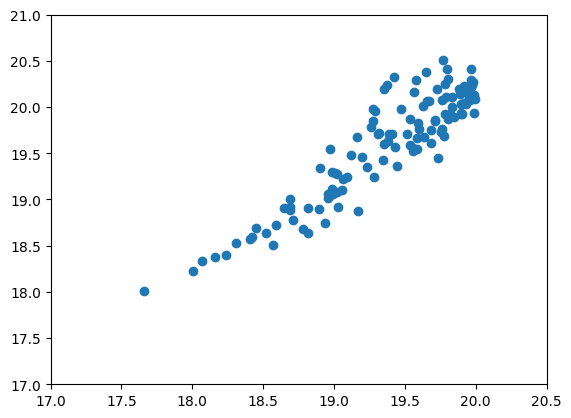

In [15]:
plt.scatter(ens._object['rMeanPSFMag_ps1_otmo'].compute().values, ens._object['gMeanPSFMag_ps1_otmo'].compute().values)
plt.xlim(17,20.5)
plt.ylim(17,21)

(17.0, 23.0)

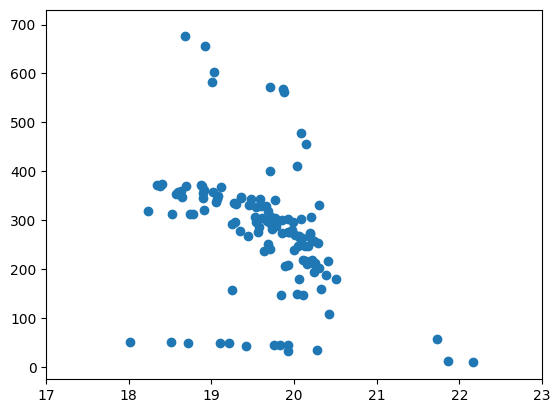

In [16]:
plt.scatter( ens._object['gMeanPSFMag_ps1_otmo'].compute().values,ens_nobs._object['nobs_total'].compute().values)
plt.xlim(17,23)

(array([ 4.,  9.,  4.,  0.,  1.,  0.,  2.,  3.,  3.,  4.,  7.,  6.,  8.,
        13., 14.,  7., 17.,  7.,  6.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  2.,  2.,  1.,  0.,  0.,  1.,  1.,  1.]),
 array([ 10.,  30.,  50.,  70.,  90., 110., 130., 150., 170., 190., 210.,
        230., 250., 270., 290., 310., 330., 350., 370., 390., 410., 430.,
        450., 470., 490., 510., 530., 550., 570., 590., 610., 630., 650.,
        670., 690., 710.]),
 <BarContainer object of 35 artists>)

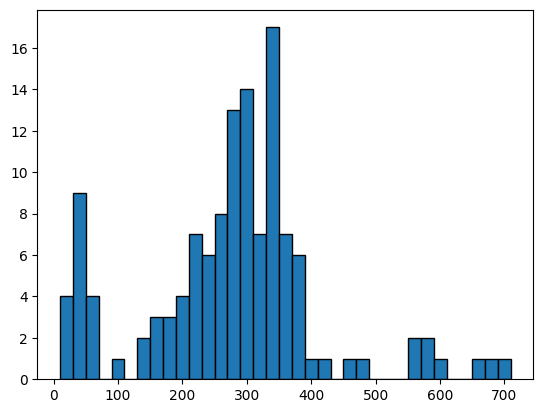

In [19]:
data = ens_nobs._object['nobs_total'].compute().values

bin_edges = range(min(data), max(data) + 21, 20) 
plt.hist(data, bins=bin_edges, edgecolor='k')  # 'k' sets black color for edges


In [6]:
# ens._source = ens._source.repartition(npartitions = 40)

In [20]:
# 9min, 13 sec on baldur, for 603 sources in 4 partitions
# 7min, 30 sec on baldur, for 603 sources in 4 partitions, Nov 7
# 5min, 14 sec on baldur, for 603 sources in 10 partitions, Nov 7
# 2min, 50 sec on baldur, for 127 sources in 4 partitions
# 3min, 3 sec on baldur, with padding 
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp = ens.batch(JaxPeriodDrwFit_instance.optimize_map, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [9]:
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_drw = ens.batch(JaxPeriodDrwFit_instance.optimize_map_drw, 'mjd_ztf_source', "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=None, n_init=100)

In [57]:
df = pd.DataFrame(columns = ['neg_log_lh','log_drw_scale', 'log_drw_amp', 'log_per_scale', 'log_per_amp'],
                   index = res_tsp.index)
for i in range(len(res_tsp)):
    df.iloc[i] = res_tsp[i]

pa_table = pa.Table.from_pandas(df)
pa.parquet.write_table(pa_table, "/astro/users/ncaplar/data/res_tsp_run_g_0.parquet")

/tmp/ipykernel_86669/1838388558.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.iloc[i] = res_tsp[i]


In [58]:
df_drw = pd.DataFrame(columns = ['neg_log_lh', 'log_drw_scale', 'log_drw_amp'],
                   index = res_tsp_drw.index)

for i in range(len(res_tsp_drw)):
    df_drw.iloc[i] = res_tsp_drw[i]
    
pa_table_drw = pa.Table.from_pandas(df_drw)
pa.parquet.write_table(pa_table_drw, "/astro/users/ncaplar/data/res_tsp_run_g_0_drw.parquet")

/tmp/ipykernel_86669/1680990878.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_drw.iloc[i] = res_tsp_drw[i]


# Alerce alerts

In [7]:
datapath = "/astro/store/epyc3/data3/alerce_alerts/parquet/"

names = []
for i in range(12,36):
    name = datapath+f"source/lcs_00{i}.parquet"
    names.append(name)

# Ensemble already initialized in the start
# ens = Ensemble()

colmap = ColumnMapper(id_col="oid",
                      time_col="mjd",
                      flux_col="magpsf_corr",
                      err_col="sigmapsf_corr_ext",
                      band_col="fid")
ens.from_parquet(source_file=names,
                #source_file=datapath+"source/lcs_000*.parquet",
                 #object_file=datapath+"object/*.parquet",
                 column_mapper=colmap,
                 sort=True)

ens.dropna()
ens.query("fid == 1", table="source").prune(30)

ens.calc_nobs()
ens._sync_tables()

In [22]:
ens._source._meta


,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,magpsf,...,rfid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious,parent_candid,has_stamp,step_id_corr,provenance
oid,,,,,,,,,,,,,,,,,,,,,


2023-11-16 09:57:11,781 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 23.19 GiB -- Worker memory limit: 31.46 GiB


In [26]:
divisions = ens._source.divisions

2023-11-16 11:12:17,978 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 23.19 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 11:12:28,077 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 23.19 GiB -- Worker memory limit: 31.46 GiB


In [35]:
n_sources_per_div =[]
for i in tqdm(range(len(divisions)-1)):
    n_sources_per_div.append(ens._source[divisions[0]:divisions[1]].compute().shape[0])


  0%|          | 0/24 [00:00<?, ?it/s]

2023-11-16 11:23:50,877 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 25.17 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 11:23:50,894 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 22.02 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 11:23:52,051 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 25.07 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 11:23:53,536 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanage

2023-11-16 11:28:53,976 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 23.23 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 11:29:03,976 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 23.23 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 11:29:13,977 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

In [36]:
n_sources_per_div

[150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461,
 150461]

2023-11-16 11:29:54,176 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 23.23 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 11:30:04,177 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 23.23 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 11:30:14,177 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

In [10]:
ens._source.npartitions

24

In [11]:
ens._source.head(5)

,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,magpsf,...,rfid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious,parent_candid,has_stamp,step_id_corr,provenance
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaace,939443434315010039,58693.443437,1,939443434315,20.405657,-1,939,71.805881,47.974764,18.651217,...,743120143.0,18.248980,0.054240,0.061382,True,False,9.474716e+17,False,bulk_1.0.0,survey_1
ZTF17aaaaace,947471584315015034,58701.471586,1,947471584315,20.489890,1,947,71.805877,47.974547,19.853916,...,743120143.0,17.541601,0.016220,0.022079,True,False,9.734760e+17,False,bulk_1.0.0,survey_1
ZTF17aaaaace,970475794315010048,58724.475799,1,970475794315,20.611511,-1,970,71.805921,47.974756,18.732740,...,743120143.0,18.196066,0.048942,0.056075,True,False,9.734760e+17,False,bulk_1.0.0,survey_1
ZTF17aaaaace,973476034315010032,58727.476030,1,973476034315,20.517332,-1,973,71.805931,47.974767,19.155125,...,743120143.0,18.001198,0.037810,0.044190,True,False,1.002489e+18,False,bulk_1.0.0,survey_1
ZTF17aaaaace,1002429524315010048,58756.429526,1,1002429524315,20.631700,-1,1002,71.805831,47.974742,19.551924,...,743120143.0,17.892044,0.023578,0.031366,True,False,1.002489e+18,False,bulk_1.0.0,survey_1


In [12]:
print(len(ens._object))

31892


In [13]:
print(len(np.unique(ens._source.index)))

31892


unique_lengths: 336


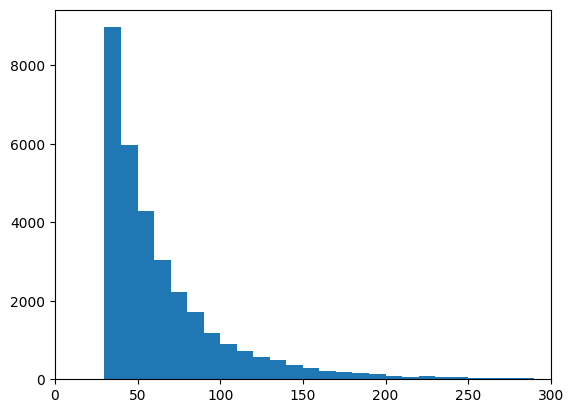

In [15]:

nobs_data = ens._object["nobs_total"].values.compute()
binwidth=10
plt.hist(nobs_data, bins=np.arange(min(nobs_data), max(nobs_data) + binwidth, binwidth))
plt.xlim(0,300)

print(f"unique_lengths: {len(np.unique(nobs_data))}")

In [21]:
type(ens._source)

dask.dataframe.core.DataFrame

2023-11-16 09:46:28,582 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 23.19 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 09:46:38,682 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 23.19 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 09:46:48,682 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

## Trying to run via ens.batch

In [ ]:
# 8 workers
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp_drw = ens.batch(JaxPeriodDrwFit_instance.optimize_map_drw, 'mjd', "magpsf_corr", "sigmapsf_corr",
                compute=True, meta=None, n_init=100)

In [16]:
# does not do anything
"""
import ctypes

def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

client.run(trim_memory)
"""

'\nimport ctypes\n\ndef trim_memory() -> int:\n    libc = ctypes.CDLL("libc.so.6")\n    return libc.malloc_trim(0)\n\nclient.run(trim_memory)\n'

In [14]:
df = pd.DataFrame(columns = ['neg_log_lh','log_drw_scale', 'log_drw_amp'],
                   index = res_tsp_drw.index)
for i in range(len(res_tsp_drw)):
    df.iloc[i] = res_tsp_drw[i]

pa_table = pa.Table.from_pandas(df)
pa.parquet.write_table(pa_table, "/astro/users/ncaplar/data/res_alerce_run_g_0_nov15.parquet")

/tmp/ipykernel_79211/2497928656.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.iloc[i] = res_tsp_drw[i]


In [17]:
# 8 workers
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
res_tsp= ens.batch(JaxPeriodDrwFit_instance.optimize_map, 'mjd', "magpsf_corr", "sigmapsf_corr",
                compute=True, meta=None, n_init=100)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
A

2023-11-16 09:43:27,782 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 23.22 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 09:43:37,783 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 23.19 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 09:43:47,783 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

In [18]:
df = pd.DataFrame(columns = ['neg_log_lh','log_drw_scale', 'log_drw_amp', 'log_per_scale', 'log_per_amp'],
                   index = res_tsp.index)
for i in range(len(res_tsp)):
    df.iloc[i] = res_tsp[i]

pa_table = pa.Table.from_pandas(df)
pa.parquet.write_table(pa_table, "/astro/users/ncaplar/data/res_alerce_run_g_0_nov16_full.parquet")

/tmp/ipykernel_88971/3733791602.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.iloc[i] = res_tsp[i]


In [19]:
res_tsp

oid
ZTF17aaaaace    [-2.5832818451922464, -0.3497222682628167, -0....
ZTF17aaaaahl    [-15.488506306082906, 13.340703583186626, -0.9...
ZTF17aaaaahn    [5.818291327884587, 0.6441204583981082, -2.310...
ZTF17aaaaald    [-9.028242294186386, -5.429838112064152, -9.26...
ZTF17aaaaall    [112.754741807653, 0.993578407670862, -2.91706...
                                      ...                        
ZTF20abyanrb    [138.07058243254954, -5.607366190874023, -6.97...
ZTF20acbergz    [-26.0293429386255, 0.5213878133052714, -6.268...
ZTF20acgcnjt    [-11.364407235683327, -4.190522662042156, -5.2...
ZTF20achvdnr    [-21.146929917994957, -7.533757597024576, -5.9...
ZTF20acitylz    [-10.401098667005625, 4.607026086136015, -7.41...
Name: oid, Length: 31892, dtype: object

2023-11-16 09:45:08,184 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 23.19 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 09:45:18,282 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 23.19 GiB -- Worker memory limit: 31.46 GiB
2023-11-16 09:45:28,284 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

## Memory issues with TAPE Alerce - investigation

In [9]:
ens._object.head(5)

,nobs_total
ZTF17aaaaace,32
ZTF17aaaaahl,64
ZTF17aaaaahn,70
ZTF17aaaaald,30
ZTF17aaaaall,35


In [10]:
ens._source.head(5)

,candid,mjd,fid,pid,diffmaglim,isdiffpos,nid,ra,dec,magpsf,...,rfid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious,parent_candid,has_stamp,step_id_corr,provenance
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaqvc,936466703115010022,58690.466701,1,936466703115,20.074652,-1,936,48.656045,46.134486,17.724680,...,741120131.0,16.373972,100.0,0.021179,True,False,9.644220e+17,False,bulk_1.0.0,survey_1
ZTF17aaaaqvc,949484693115015023,58703.484699,1,949484693115,20.708147,1,949,48.656091,46.134409,18.910578,...,741120131.0,16.020426,100.0,0.009672,True,False,9.644220e+17,False,bulk_1.0.0,survey_1
ZTF17aaaaqvc,952473143115010051,58706.473148,1,952473143115,20.798561,-1,952,48.655946,46.134486,18.339853,...,741120131.0,16.246412,100.0,0.009514,True,False,9.644220e+17,False,bulk_1.0.0,survey_1
ZTF17aaaaqvc,958488853115010016,58712.488854,1,958488853115,19.742458,-1,958,48.656006,46.134442,17.655280,...,741120131.0,16.394827,100.0,0.016132,True,False,9.644220e+17,False,bulk_1.0.0,survey_1
ZTF17aaaaqvc,964422013115015012,58718.422014,1,964422013115,19.934868,1,964,48.655914,46.134375,18.239952,...,741120131.0,15.957507,100.0,0.013410,True,False,9.814993e+17,False,bulk_1.0.0,survey_1


In [11]:
ts = ens.to_timeseries('ZTF18aayojot') # provided a target object id
ts.data['mjd']

band  index
1     0        58653.357627
      1        58654.324907
      2        58660.353924
      3        58663.441678
      4        58665.249502
                   ...     
      75       59145.208391
      76       59150.153692
      77       59167.135972
      78       59169.089468
      79       59171.139514
Name: mjd, Length: 80, dtype: float64

In [12]:
oid = ens._source.index.compute()
time = ens._source['mjd'].compute()
y = ens._source['magpsf_corr'].compute()
yerr = ens._source['sigmapsf_corr_ext'].compute()

In [13]:
ens._source.index.compute()

Index(['ZTF17aaaaqvc', 'ZTF17aaaaqvc', 'ZTF17aaaaqvc', 'ZTF17aaaaqvc',
       'ZTF17aaaaqvc', 'ZTF17aaaaqvc', 'ZTF17aaaaqvc', 'ZTF17aaaaqvc',
       'ZTF17aaaaqvc', 'ZTF17aaaaqvc',
       ...
       'ZTF20abshlkr', 'ZTF20abshlkr', 'ZTF20abshlkr', 'ZTF20abshlkr',
       'ZTF20abshlkr', 'ZTF20abshlkr', 'ZTF20abshlkr', 'ZTF20abshlkr',
       'ZTF20abshlkr', 'ZTF20abshlkr'],
      dtype='string', name='oid', length=2082032)

In [14]:
# creates an array of indices, sorted by unique element
idx_sort = np.argsort(oid)

In [15]:
oid_sort = oid[idx_sort].values
y_sort = y[idx_sort].values
t_sort = time[idx_sort].values
yerr_sort = yerr[idx_sort].values

/tmp/ipykernel_123619/3822546531.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sort = y[idx_sort].values
/tmp/ipykernel_123619/3822546531.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_sort = time[idx_sort].values
/tmp/ipykernel_123619/3822546531.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yerr_sort = yerr[idx_sort].values


In [16]:
vals, idx_start, count = np.unique(oid_sort, return_counts=True, return_index=True)
# splits the indices into separate arrays
oid_split = np.split(oid_sort, idx_start[1:])
t_split = np.split(t_sort, idx_start[1:])
y_split = np.split(y_sort, idx_start[1:])
yerr_split = np.split(yerr_sort, idx_start[1:])

In [2]:
plt.errorbar(t_split[10000], y_split[10000], yerr=yerr_split[10000], fmt=".k", capsize=2)
plt.errorbar(ts.data['mjd'], ts.data['magpsf_corr']+0.1, yerr=ts.data['sigmapsf_corr_ext'], fmt=".k", capsize=2, color = 'red', alpha = 0.5)

NameError: name 'plt' is not defined

In [18]:

# with for loop, takes 2min, 22 sec for 50
from tqdm import tqdm
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()
results = np.zeros((15000,5))
for i in tqdm(range(15000)):
    single_res = JaxPeriodDrwFit_instance.optimize_map(t_split[i], y_split[i], yerr_split[i])
    results[i] = single_res


100%|██████████| 15000/15000 [1:01:00<00:00,  4.10it/s]


In [66]:
# 2 minutes, single core 
JaxPeriodDrwFit_instance = JaxPeriodDrwFit.JaxPeriodDrwFit()

def optimize_single_instance(args):
    t, y, yerr = args
    return JaxPeriodDrwFit_instance.optimize_map(t, y, yerr)
# Combine the data into a list of tuples
instances_data = zip(t_split[68:75], y_split[68:75], yerr_split[68:75])
results = np.zeros((50,5))
results = list(map(optimize_single_instance, instances_data))
results_array = np.vstack(results)

In [67]:
results_array

array([[ -38.74102584,   14.26275297, -137.43917726, -104.52546299,
         -18.27369624],
       [  -7.01966779,    1.88036174,   -6.25686089,    1.32975751,
          -1.09088833],
       [ -20.23065637,    2.3278281 ,   -2.5671997 ,    1.71051104,
          -1.30712254],
       [ -67.23310942,    2.2642459 ,   -0.95310517,    2.15878256,
          -1.06902239],
       [ -24.73354735,    1.0587042 ,   -1.27663303,    1.65405066,
          -1.25245054],
       [  70.54009494,    0.75017142,   -0.23696218,    1.45340528,
          -0.60770948],
       [ -16.7962054 ,    0.90711504,   -4.36292516,    0.75404176,
          -1.12998827]])

In [21]:
import multiprocessing

print("Number of cpu : ", multiprocessing.cpu_count())

Number of cpu :  64


In [28]:
def worker(n):
    return n * n

if __name__ == "__main__":
    with multiprocessing.Pool(4) as p:
        print(p.map(worker, range(10)))

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [65]:
instances_data = zip(t_split[0:70], y_split[0:70], yerr_split[0:70])
# Create a Pool for parallel execution
with multiprocessing.Pool(32) as pool:
    print("Number of worker processes:", pool._processes) 
    # Map the optimization function to the data for parallel execution
    result = list(pool.map(optimize_single_instance, instances_data))

result_array = np.vstack(result)

Number of worker processes: 32


[mutex.cc : 2416] RAW: Check w->waitp->cond == nullptr failed: Mutex::Fer while waiting on Condition


KeyboardInterrupt: 

In [55]:
result_array

array([[-2.65660374e+00,  7.79923970e-01, -1.73634752e+00,
         4.58753654e-02, -6.74098907e-01],
       [-1.49136865e+01,  1.41364239e+01, -9.55274972e-01,
         2.15099867e+00, -5.18380216e-01],
       [ 4.50052258e+00,  5.48400064e-01, -9.60406182e-01,
         1.14109118e+00, -1.10310577e+00],
       [-2.71241343e+01, -6.19975441e+00, -7.51087814e+00,
         1.30551216e-01, -5.24588759e+00],
       [-3.46494743e+01, -4.68511076e+00, -5.91385545e+00,
         2.90351891e+00, -1.82207636e+00],
       [ 1.88889296e+01,  6.99145329e-01, -5.72958933e-01,
         5.54837770e-01, -8.34042857e-01],
       [-3.14778232e+01,  3.46235820e-01, -7.15263316e+00,
         2.98025952e+00, -1.62807765e+00],
       [-3.14920702e+01, -8.59688192e+00, -6.14726063e+00,
         6.91520911e-01, -1.44399186e+00],
       [ 4.29180368e+00,  3.94186588e+00, -2.42855301e+00,
        -4.35901824e+02, -2.78953275e+00],
       [-1.02236305e+01,  1.24194129e+01, -1.09570028e+00,
         2.36451562e+00

In [49]:
instances_data = zip(t_split[0:50], y_split[0:50], yerr_split[0:50])
instances_data
list(instances_data)

[(array([58693.4434375, 58701.4715856, 58724.4757986, 58727.4760301,
         58756.4295255, 58778.305787 , 58781.4110185, 58787.4287731,
         58833.1969792, 58834.2181481, 58836.2272222, 58837.2292708,
         58859.1357755, 58863.1666319, 58893.1726157, 58896.2049537,
         59064.4664931, 59091.4205208, 59092.4225926, 59096.4862153,
         59118.4644444, 59120.3542824, 59121.3696065, 59123.4310648,
         59125.4212269, 59141.4320255, 59151.387037 , 59155.3850116,
         59168.3725   , 59170.4329282, 59185.4098032, 59226.2179051]),
  array([18.24898 , 17.541601, 18.196066, 18.001198, 17.892044, 18.127958,
         17.905586, 17.86679 , 18.183115, 18.297459, 17.975367, 17.867249,
         18.291506, 18.091867, 18.275812, 18.057198, 18.420923, 18.10704 ,
         18.27189 , 18.289568, 17.581831, 18.285633, 18.2358  , 18.166319,
         18.21699 , 17.839497, 18.044392, 17.970263, 17.834183, 17.818405,
         18.295765, 17.5671  ]),
  array([0.06138228, 0.02207859, 0.056

In [1]:
2+2

4